# Trajectory Optimization Example 4

Similar to example 2. Construct a trajectory with multiple states (pose + velocity). Lock the first state (pose + velocity), and optimize the rest states (pose + velocity) with addtional velocity measurements at interpolated times.


In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 18,
    # 'xtick.labelsize': 18,
    # 'ytick.labelsize': 18,
})

np.set_printoptions(6, suppress=True)

from pylgmath import Transformation, se3op
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar

In [2]:
def plot_trajectory(qcd, state_vars, T_iv_meas, T_iv_noise, w_iv_inv_meas, w_iv_inv_noise):
  #
  traj = TrajectoryInterface(qcd=qcd)
  for t, T_vi, w_iv_inv in state_vars:
    traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)
  #
  cost_terms = []
  loss_func = L2LossFunc()
  # pose measurements -> cost terms
  noise_model = StaticNoiseModel(T_iv_noise)
  for t, T_iv in T_iv_meas:
    intp_pos = traj.get_pose_interpolator(Time(secs=t))
    error_func = se3ev.tran2vec(se3ev.compose(intp_pos, SE3StateVar(T_iv, locked=True)))
    cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    cost_terms.append(cost_term)
  # velocity measurements -> cost terms
  noise_model = StaticNoiseModel(w_iv_inv_noise)
  for t, w in w_iv_inv_meas:
    intp_vel = traj.get_velocity_interpolator(Time(secs=t))
    error_func = vspaceev.add(VSpaceStateVar(w, locked=True), vspaceev.neg(intp_vel))
    cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    cost_terms.append(cost_term)
  #
  opt_prob = OptimizationProblem()
  opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
  opt_prob.add_cost_term(*traj.get_prior_cost_terms())
  opt_prob.add_cost_term(*cost_terms)

  solver = DoglegGaussNewtonSolver(opt_prob, verbose=False)
  solver.optimize()

  # knot times
  knot_times = [x[0] for x in state_vars]
  knot_vels = np.array([traj.get_velocity_interpolator(Time(secs=t)).evaluate().flatten() for t in knot_times])
  knot_poses = [traj.get_pose_interpolator(Time(secs=t)).evaluate().inverse().matrix() for t in knot_times]
  knot_poses_vec = np.array([se3op.tran2vec(x).flatten() for x in knot_poses])

  # measurement values
  meas_pose_times = [x[0] for x in T_iv_meas]
  meas_poses = [x[1].matrix() for x in T_iv_meas]
  meas_poses_vec = np.array([se3op.tran2vec(x).flatten() for x in meas_poses])
  meas_vel_times = [x[0] for x in w_iv_inv_meas]
  meas_vels = np.array([x[1].flatten() for x in w_iv_inv_meas])

  # plot values
  plot_times = lambda: list(np.arange(0.0, T_TOTAL, 0.02 * T_TOTAL)) + [T_TOTAL]
  plot_intp_vels = np.array([traj.get_velocity_interpolator(Time(secs=t)).evaluate().squeeze() for t in plot_times()])
  plot_intp_poses = [traj.get_pose_interpolator(Time(secs=t)).evaluate().inverse().matrix() for t in plot_times()]
  plot_intp_poses_vec = np.array([se3op.tran2vec(x).flatten() for x in plot_intp_poses])

  fig, axs = plt.subplots(1, 4, figsize=(30, 6))
  fig.subplots_adjust(left=0.16, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)

  # pose (translation)
  axs[0].plot(plot_times(), plot_intp_poses_vec[:, 0], 'r-', label='x-axis', linewidth=1)
  axs[0].plot(plot_times(), plot_intp_poses_vec[:, 1], 'g-', label='y-axis', linewidth=1)
  axs[0].plot(plot_times(), plot_intp_poses_vec[:, 2], 'b-', label='z-axis', linewidth=1)
  if len(knot_times):
    axs[0].scatter(knot_times, knot_poses_vec[:, 0], s=20, color='r', facecolors='none')
    axs[0].scatter(knot_times, knot_poses_vec[:, 1], s=20, color='g', facecolors='none')
    axs[0].scatter(knot_times, knot_poses_vec[:, 2], s=20, color='b', facecolors='none')
  if len(meas_pose_times):
    axs[0].scatter(meas_pose_times, meas_poses_vec[:, 0], marker="*", s=160, color='r')
    axs[0].scatter(meas_pose_times, meas_poses_vec[:, 1], marker="*", s=160, color='g')
    axs[0].scatter(meas_pose_times, meas_poses_vec[:, 2], marker="*", s=160, color='b')
  axs[0].set_xlabel('time [$s$]')
  axs[0].set_ylabel('translation [$m$]')
  axs[0].set_title('$T_{0k}$ (Translation)')
  handles, labels = axs[0].get_legend_handles_labels()

  # pose (rotation)
  axs[1].plot(plot_times(), plot_intp_poses_vec[:, 3], 'r-', label='x-axis', linewidth=1)
  axs[1].plot(plot_times(), plot_intp_poses_vec[:, 4], 'g-', label='y-axis', linewidth=1)
  axs[1].plot(plot_times(), plot_intp_poses_vec[:, 5], 'b-', label='z-axis', linewidth=1)
  if len(knot_times):
    axs[1].scatter(knot_times, knot_poses_vec[:, 3], s=20, color='r', facecolors='none')
    axs[1].scatter(knot_times, knot_poses_vec[:, 4], s=20, color='g', facecolors='none')
    axs[1].scatter(knot_times, knot_poses_vec[:, 5], s=20, color='b', facecolors='none')
  if len(meas_pose_times):
    axs[1].scatter(meas_pose_times, meas_poses_vec[:, 3], marker="*", s=160, color='r')
    axs[1].scatter(meas_pose_times, meas_poses_vec[:, 4], marker="*", s=160, color='g')
    axs[1].scatter(meas_pose_times, meas_poses_vec[:, 5], marker="*", s=160, color='b')
  axs[1].set_xlabel('time [$s$]')
  axs[1].set_ylabel('rotation [$rad$]')
  axs[1].set_title('$T_{0k}$ (Rotation)')

  # velocity (translation)
  axs[2].plot(plot_times(), plot_intp_vels[:, 0], 'r-', label='x-axis', linewidth=1)
  axs[2].plot(plot_times(), plot_intp_vels[:, 1], 'g-', label='y-axis', linewidth=1)
  axs[2].plot(plot_times(), plot_intp_vels[:, 2], 'b-', label='z-axis', linewidth=1)
  if len(knot_times):
    axs[2].scatter(knot_times, knot_vels[:, 0], s=20, color='r', facecolors='none')
    axs[2].scatter(knot_times, knot_vels[:, 1], s=20, color='g', facecolors='none')
    axs[2].scatter(knot_times, knot_vels[:, 2], s=20, color='b', facecolors='none')
  if len(meas_vel_times):
    axs[2].scatter(meas_vel_times, meas_vels[:, 0], marker="*", s=160, color='r')
    axs[2].scatter(meas_vel_times, meas_vels[:, 1], marker="*", s=160, color='g')
    axs[2].scatter(meas_vel_times, meas_vels[:, 2], marker="*", s=160, color='b')
  axs[2].set_xlabel('time [$s$]')
  axs[2].set_ylabel('translational vel. [$m/s$]')
  axs[2].set_title('$w^{0k}_k$ (Translation)')

  # velocity (rotation)
  axs[3].plot(plot_times(), plot_intp_vels[:, 3], 'r-', label='x-axis', linewidth=1)
  axs[3].plot(plot_times(), plot_intp_vels[:, 4], 'g-', label='y-axis', linewidth=1)
  axs[3].plot(plot_times(), plot_intp_vels[:, 5], 'b-', label='z-axis', linewidth=1)
  if len(knot_times):
    axs[3].scatter(knot_times, knot_vels[:, 3], s=20, color='r', facecolors='none')
    axs[3].scatter(knot_times, knot_vels[:, 4], s=20, color='g', facecolors='none')
    axs[3].scatter(knot_times, knot_vels[:, 5], s=20, color='b', facecolors='none')
  if len(meas_vel_times):
    axs[3].scatter(meas_vel_times, meas_vels[:, 3], marker="*", s=160, color='r')
    axs[3].scatter(meas_vel_times, meas_vels[:, 4], marker="*", s=160, color='g')
    axs[3].scatter(meas_vel_times, meas_vels[:, 5], marker="*", s=160, color='b')
  axs[3].set_xlabel('time [$s$]')
  axs[3].set_ylabel('rotational vel. [$rad/s$]')
  axs[3].set_title('$w^{0k}_k$ (Rotation)')

  fig.legend(handles, labels, loc='lower center', ncol=3)

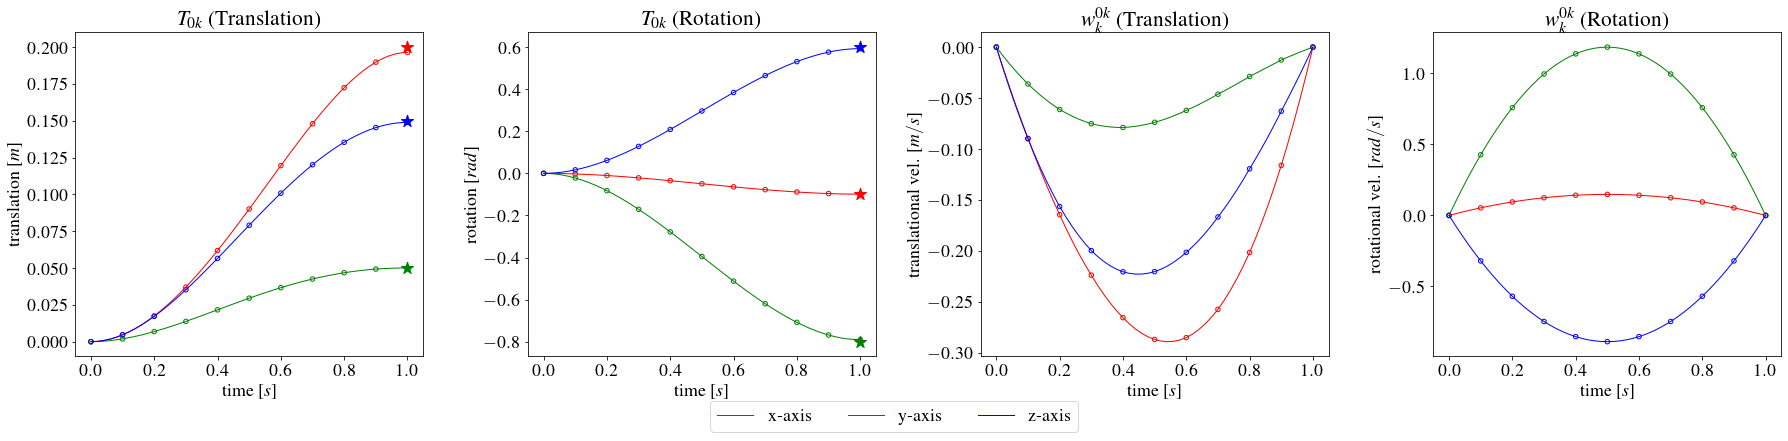

In [3]:
## Qc
qcd = np.ones(6)
## states
NUM_STATES = 10  # number of states in addition to the initial state
T_TOTAL = 1  # time horizon
DT = T_TOTAL / NUM_STATES  # dt
states = [(DT * i, Transformation(), 0 * np.ones((6, 1))) for i in range(NUM_STATES + 1)]
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity
state_vars[-1][2].locked = True  # lock last velocity
## pose measurements
T_iv_noise = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
T_iv_meas = []
T_iv_meas.append((1.0 * T_TOTAL, Transformation(xi_ab=np.array([[0.2, 0.05, 0.15, -0.1, -0.8, 0.6]]).T)))
## velocity measurements
w_iv_inv_noise = np.diag([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])
w_iv_inv_meas = []
##
plot_trajectory(qcd, state_vars, T_iv_meas, T_iv_noise, w_iv_inv_meas, w_iv_inv_noise)

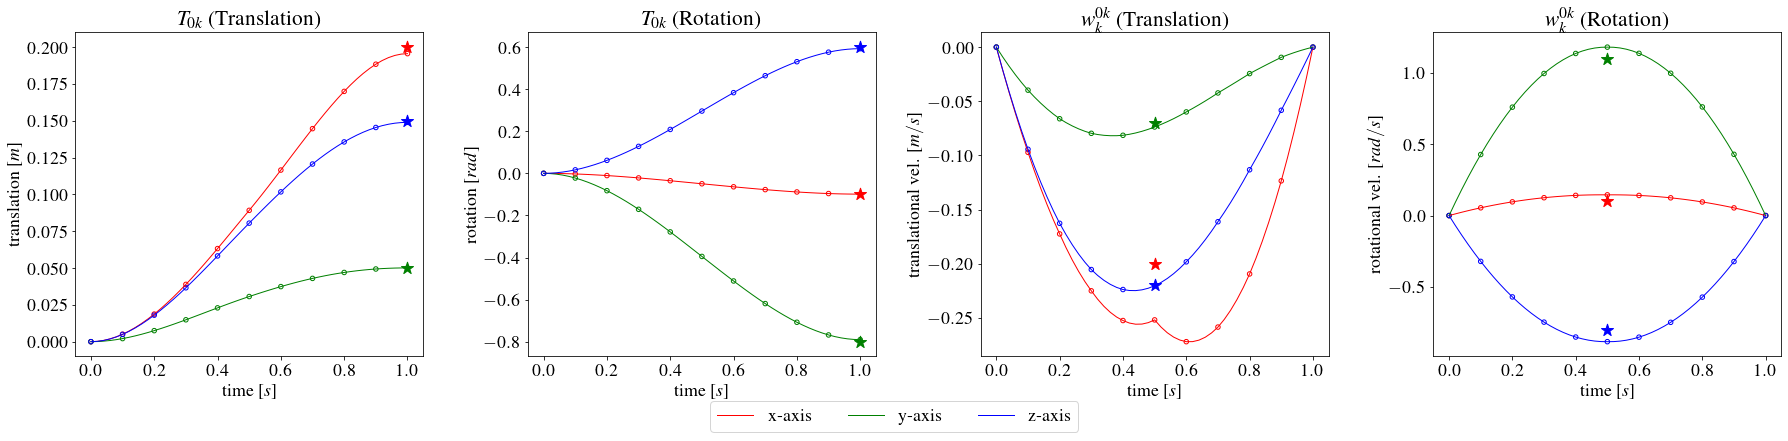

In [4]:
## Qc
qcd = np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])
## states
NUM_STATES = 10  # number of states in addition to the initial state
T_TOTAL = 1  # time horizon
DT = T_TOTAL / NUM_STATES  # dt
states = [(DT * i, Transformation(), 0 * np.ones((6, 1))) for i in range(NUM_STATES + 1)]
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity
state_vars[-1][2].locked = True  # lock last velocity
## pose measurements
T_iv_noise = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
T_iv_meas = []
T_iv_meas.append((1.0 * T_TOTAL, Transformation(xi_ab=np.array([[0.2, 0.05, 0.15, -0.1, -0.8, 0.6]]).T)))
## velocity measurements
w_iv_inv_noise = np.diag([1e-1, 1e0, 1e0, 1e0, 1e0, 1e0])
w_iv_inv_meas = []
w_iv_inv_meas.append((0.5 * T_TOTAL, np.array([[-0.2, -0.07, -0.22, 0.1, 1.1, -0.8]]).T))
##
plot_trajectory(qcd, state_vars, T_iv_meas, T_iv_noise, w_iv_inv_meas, w_iv_inv_noise)

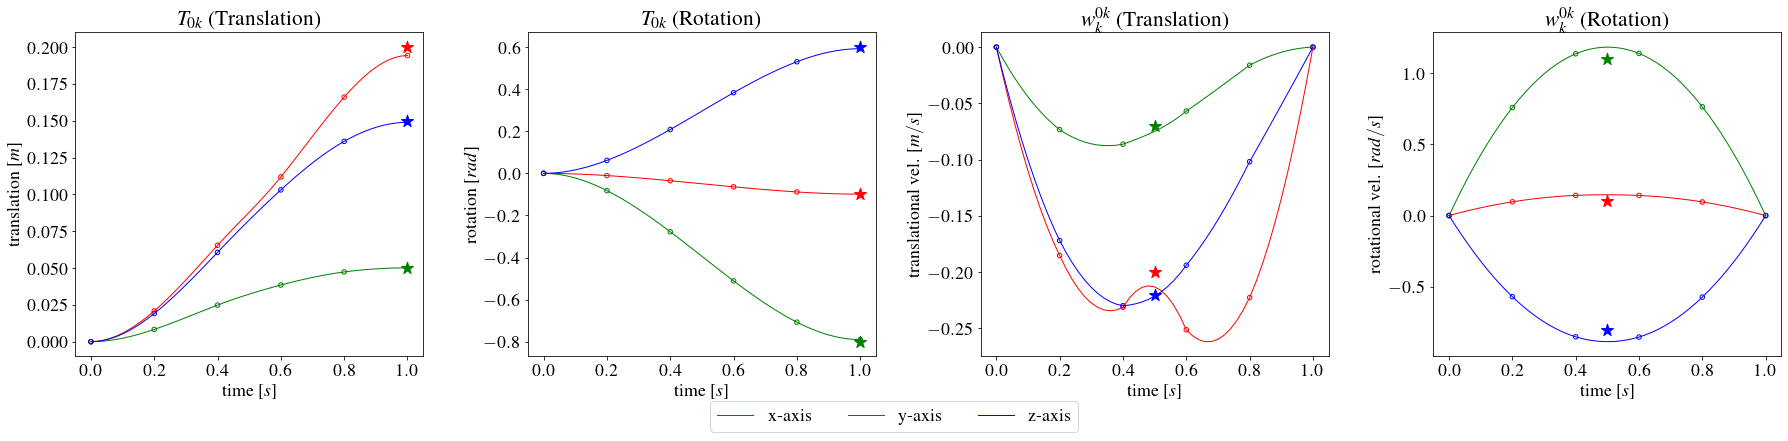

In [5]:
## Qc
qcd = np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])
## states
NUM_STATES = 5  # number of states in addition to the initial state
T_TOTAL = 1  # time horizon
DT = T_TOTAL / NUM_STATES  # dt
states = [(DT * i, Transformation(), 0 * np.ones((6, 1))) for i in range(NUM_STATES + 1)]
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity
state_vars[-1][2].locked = True  # lock last velocity
## pose measurements
T_iv_noise = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
T_iv_meas = []
T_iv_meas.append((1.0 * T_TOTAL, Transformation(xi_ab=np.array([[0.2, 0.05, 0.15, -0.1, -0.8, 0.6]]).T)))
## velocity measurements
w_iv_inv_noise = np.diag([1e-2, 1e0, 1e0, 1e0, 1e0, 1e0])
w_iv_inv_meas = []
w_iv_inv_meas.append((0.5 * T_TOTAL, np.array([[-0.2, -0.07, -0.22, 0.1, 1.1, -0.8]]).T))
##
plot_trajectory(qcd, state_vars, T_iv_meas, T_iv_noise, w_iv_inv_meas, w_iv_inv_noise)